# Lab Deep Learning / Multi-Layer Perceptron for regression / in pytorch



## Objective:

The objective of this lab is to demonstrate the use of Neural Networks to perform non-linear regression.
We will use a simple NN with 1 hidden layer. The hidden layer has $n_h$ (you will test various values of $n_h$) hidden units and either a ```sigmoid```, ```relu``` or ```tanh``` activation.
Since we perform a regression task the output $\hat{y} \in \mathbb{R}$ and  there is no output activation (linear).

You will perform 1000 iterations (epochs) of SGD to find the parameters.

You will then apply the network to the two datasets A and B.

Note: for this lab, we do not separate the dataset into a train, validation and test part. We simply check the ```capacity``` of the network to model the training data.

**Question**: according to the obtained loss, discuss the choice of ```sigmoid```, ```relu``` or ```tanh```.



### Data normalization

You should normalize the data to zero mean and unit standard deviation

### Model

There are various ways to write a NN model in pytorch.

In this lab, you will write three different implementations:
- **Model A**: manually defining the parameters (W1,b1,w2,b2), writting the forward equations, writting the loss equation, calling the .backward() and manually updating the weights using W1.grad. You will write the loop to perform 1000 epochs.
- **Model B**: using the Sequential class of pytorch
- **Model C**: a custom torch.nn.Module class for this.

For Model B and C, you will use the ready made loss and optimization from the nn and optim packages. You can use the same code to optimize the parameters of Model B and C.

### Loss

Since we are dealing with a regression problem, we will use a Mean Square Error loss: write it by-hand for Model A and use ```torch.nn.MSELoss``` for Model B and C.

### Parameters update/ Optimization

For updating the parameters, we will use as optimizer a simple SGD algorithm (use ```torch.optim.SGD``` for Model B and C) with a learning rate of 0.05.

Don't forget that an optimizer is applied to a set of parameters (```my_model.parameters()``` gives the parameters of the network for Model B and C).
Once the gradients have been computed (after the backpropagation has been performed), you can perform one step of optimization (using ```optimizer.step()``` for Model B and C).

### Backward propagation

Backpropagation is automatically performed in pytorch using the ```autograd``` package.
First, reset the gradients of all parameters (using ```optimizer.zero_grad()``` for Model B and C), then perform the backpropagation ```loss.backward()```.

### Regularization

- How can you add a Ridge (L2) regularization ? this can be done easely within the definition of the ```optimizer```.
- How can you add a Lasso (L1) regularization ? this has to be done manually at each iteration, by adding something to the loss before backpropagation.

**Question**: discuss the use of the Ridge and Lasso regularization for each dataset.



## Load the python packages

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

## Datasets

We will use two different datasets. For both $x$ has dimensions $(m,n_{in}=1)$ and $y$ has dimensions $(m,n_{out}=1)$ where $m$ is the number of examples.



In [2]:
def F_do_dataset_parab(m):
    x_data = torch.linspace(-1, 1, m)
    noise_data = 0.2*torch.rand(m)
    y_data = x_data.pow(2) + noise_data

    # --- change vectos to matrix
    x_data = torch.unsqueeze(x_data, dim=1)
    y_data = torch.unsqueeze(y_data, dim=1)
    return x_data, y_data

def F_do_dataset_sin(m):
    x_data = torch.arange(0, m, dtype=torch.float32)
    noise_data = 0.2*torch.rand(m)
    y_data = torch.sin(2*np.pi*x_data*0.001) + noise_data

    # --- change vectos to matrix
    x_data = torch.unsqueeze(x_data, dim=1)
    y_data = torch.unsqueeze(y_data, dim=1)
    return x_data, y_data

size of x_data: torch.Size([3000, 1])
size of y_data: torch.Size([3000, 1])


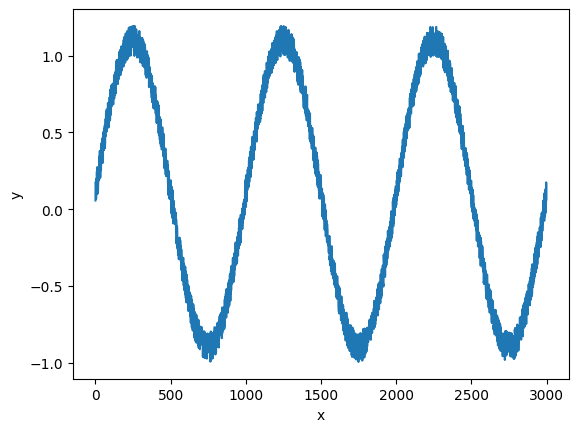

In [123]:
# --- Dataset 1
#x_data, y_data = F_do_dataset_parab(m=100)
# --- Dataset 2
x_data, y_data = F_do_dataset_sin(m=3000)

plt.plot(x_data.numpy(), y_data.numpy());
plt.xlabel('x'), plt.ylabel('y');

print('size of x_data:', x_data.size())
print('size of y_data:', y_data.size())

## Data standardization

We standardize the input data (substract mean and divide by standard-deviation)

In [124]:
# --- START CODE HERE
x_data = (x_data-torch.mean(x_data))/torch.std(x_data)
y_data = (y_data-torch.mean(y_data))/torch.std(y_data)

# --- END CODE HERE

## Hyper-parameters definition

In [125]:
n_in = 1
n_h = 10
n_out = 1

nb_epoch = 20000
learning_rate_alpha = 0.05
param_momentum = 0.01
param_L1_weight = 0.001
param_L2_weight = 0.01

## Model A (writting the network equations)

For model A, you will define the variables and write the equations of the network yourself (as you would do in numpy).
However you will use ```torch tensors``` instead of ```numpy array```.

***Why ?*** because torch tensors will allows you to automatically get the gradient. You will use ```loss.backward()``` to launch the backpropagation from the ```loss``` variable.
Then, for all torch tensors you have created and for which you have declared ```requires_grad=True```, you will get the gradient of ```loss```with respect to this variable in the field ```.grad```.

***Example*** ```W1 = torch.tensors(..., requires_grad=True)``` ... ```loss.backward()``` will have the gradient $\frac{d Loss}{d W1}$in ```W1.grad```.

### Initialize the variables

**Note**: In order to avoid neuron saturation and that all the neurons learn the same thing, the matrix should be initialized to a small random value (see https://pytorch.org/docs/stable/generated/torch.nn.Linear.html for details). Because of this, W1 and W2 should be first define as small random; **then** set to ```requires_grad=True```.

In [126]:
# --- START CODE HERE
W1 = torch.randn(n_in,n_h,requires_grad=True)
b1 = torch.randn(1,n_h,requires_grad=True)
W2 = torch.randn(n_h,n_out,requires_grad=True)
b2 = torch.randn(3000,1,requires_grad=True)
# --- END CODE HERE
print(W1)

tensor([[-0.8796,  0.4654, -0.9549, -1.6739,  1.2543,  0.1586, -0.2852,  0.4200,
         -1.9108,  3.6602]], requires_grad=True)


### Define the model

We will denote by ```H``` the pre-activation (value before the non-linearity) and by ```A``` the activation (value after the non-linearity).

In [127]:

def model(X):

    # --- H is the results of the first projection

    # --- H is then transformed by a non-linearity to A

    # --- START CODE HERE

    H=X.mm( W1)+b1

    #H=H.clamp(min=0)
    H=torch.sigmoid(H)
    y_pred=H.mm(W2)+b2
    # --- END CODE HERE
    return y_pred

### Train the model

**Note**: when updating the parameters (W1,b1,W2,b2) you should use an "in-place" update: ```W1 -= ...``` instead of ```W1 = W1 - ...```; otherwise ```W1``` will be replaced by its value and its gradient field will not exist anymore.

In [118]:
learning_rate_alpha=0.05

In [128]:
for epoch in range(0, nb_epoch):
    # --- X (m, n_in)
    # --- Y (m, n_out)
    # --- START CODE HERE
    y_pred=model(x_data)#forward
    loss = (y_pred - y_data).pow(2).sum()/3000# mean -square - error
    # --- END CODE HERE

    if epoch % 1000 == 0:
        print('epoch {}, loss {}'.format(epoch, loss))

    loss.backward()

    with torch.no_grad():
        # --- START CODE HERE
        W1-=learning_rate_alpha*W1.grad
        b1-=learning_rate_alpha*b1.grad
        W2-=learning_rate_alpha*W2.grad
        b2-=learning_rate_alpha*b2.grad
        # --- END CODE HERE
        W1.grad.zero_()
        b1.grad.zero_()
        W2.grad.zero_()
        b2.grad.zero_()


epoch 0, loss 3.620312452316284
epoch 1000, loss 1.834086298942566
epoch 2000, loss 1.6898787021636963
epoch 3000, loss 1.56177818775177
epoch 4000, loss 1.4218212366104126
epoch 5000, loss 1.236782193183899
epoch 6000, loss 1.00980806350708
epoch 7000, loss 0.826920747756958
epoch 8000, loss 0.716526210308075
epoch 9000, loss 0.6492034792900085
epoch 10000, loss 0.6002736687660217
epoch 11000, loss 0.5590279698371887
epoch 12000, loss 0.5217733383178711
epoch 13000, loss 0.487295538187027
epoch 14000, loss 0.4551455080509186
epoch 15000, loss 0.42510154843330383
epoch 16000, loss 0.397011935710907
epoch 17000, loss 0.37074974179267883
epoch 18000, loss 0.34620097279548645
epoch 19000, loss 0.32325878739356995


### Plotting the results

We will super-impose the biases of the first layer to better understand how the model has fit the sinusoidal curve. Please explain what it does.

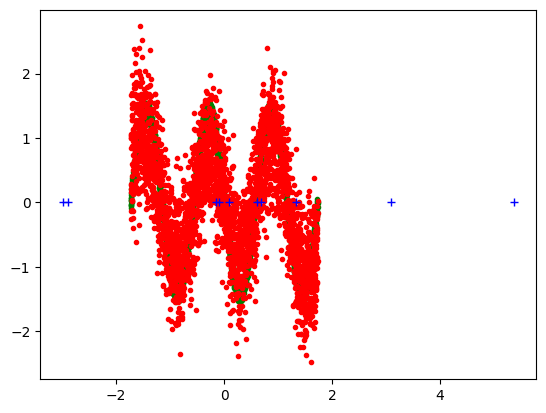

In [99]:
# ----------------
plt.plot(x_data.numpy(), y_data.numpy(), 'g.');
plt.plot(x_data.numpy(), y_pred.detach().numpy(), 'r.');
# super-impose the biases of the first layer
plt.plot(b1.detach().numpy(), np.zeros((1,10)), 'b+');

## Model B (using Sequential class)

Here, you will write the network using the nn.Sequential class.
With this you can use the ready-made layers ``torch.nn.Linear``,``torch.nn.Tanh``, ...

In [110]:
# --- START CODE HERE
model = torch.nn.Sequential(
     torch.nn.Linear(1,n_h),
     torch.nn.ReLU(),
     torch.nn.Linear(n_h, 1),
)
criterion = torch.nn.MSELoss(reduction='mean')
learning_rate = 0.05
for t in range(500):
    y_pred = model(x_data)
    loss = criterion(y_pred, y_data)
    if t % 20 == 0:
        print('t {}, loss {}'.format(t, loss))
    model.zero_grad()
    loss.backward()
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad
# --- END CODE HERE

t 0, loss 1.1572456359863281
t 20, loss 0.929340660572052
t 40, loss 0.9216408729553223
t 60, loss 0.9146489500999451
t 80, loss 0.9079986810684204
t 100, loss 0.9015045762062073
t 120, loss 0.895026683807373
t 140, loss 0.888430655002594
t 160, loss 0.8815883994102478
t 180, loss 0.8743777871131897
t 200, loss 0.866685152053833
t 220, loss 0.8584282994270325
t 240, loss 0.8496035933494568
t 260, loss 0.8403400182723999
t 280, loss 0.8308776617050171
t 300, loss 0.8214342594146729
t 320, loss 0.8121094703674316
t 340, loss 0.8029135465621948
t 360, loss 0.7938103079795837
t 380, loss 0.7847827672958374
t 400, loss 0.7758306264877319
t 420, loss 0.7669646739959717
t 440, loss 0.7581990361213684
t 460, loss 0.7495489120483398
t 480, loss 0.7410285472869873


## Model C (using a class definition)

Here, you will write the network using the recommended pytorch way; i.e. by defining a class.
This class inherit from the main class ```torch.nn.Module```.
You only need to write the ```__init__``` method and the ```forward``` method.

In object programming, the ```__init__``` method defines the attributes of your class. Since the attributes of your  network are the parameters to be trained (weights and biases), you should declare in the ```__init``` all the layers that involve parameters to be trained (mostly the ```Linear```layers which perform the matrix multiplication).

The ```forward``` method contains the code of the forward pass itself. It can of course call attributes defined in the ```__init___``` method. It is the method used when calling ```model(x)```.

As before, the model created will have all its parameters accessible as a dictionary and can be accessed using ```model.parameters()```.

Classes are convenient way to write more complex network than what you can do with ```nn.sequential```. Note that you can actually include a ```nn.sequential``` in your class.

In [132]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # --- START CODE HERE
        self.linear1=torch.nn.Linear(1,n_h)
        self.linear2=torch.nn.Linear(n_h,1)
        # --- END CODE HERE

    def forward(self, x):

        # --- START CODE HERE
        h_relu=self.linear1(x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        # --- END CODE HERE

        return y_pred
model=Net()
# --- START CODE HERE
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
for t in range(500):
    y_pred = model(x_data)
    loss = criterion(y_pred, y_data)
    if t % 20 == 0:
        print('t {}, loss {}'.format(t, loss))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
# --- END CODE HERE

t 0, loss 0.9669822454452515
t 20, loss 0.9462851285934448
t 40, loss 0.9369762539863586
t 60, loss 0.9295166730880737
t 80, loss 0.9232097864151001
t 100, loss 0.9175245761871338
t 120, loss 0.912306010723114
t 140, loss 0.9074645042419434
t 160, loss 0.9028807878494263
t 180, loss 0.8984521627426147
t 200, loss 0.8941147327423096
t 220, loss 0.8898341655731201
t 240, loss 0.8855923414230347
t 260, loss 0.8813797831535339
t 280, loss 0.8771913051605225
t 300, loss 0.8730239868164062
t 320, loss 0.8688789010047913
t 340, loss 0.8647547960281372
t 360, loss 0.8606523275375366
t 380, loss 0.8565725684165955
t 400, loss 0.8525149822235107
t 420, loss 0.848478376865387
t 440, loss 0.8444605469703674
t 460, loss 0.8404569625854492
t 480, loss 0.8364595770835876


## Model B+C

### Criterion and Optimization

The code of Model A is self-contained, i.e. it already contains all necessary instruction to perform forward, loss, backward and parameter updates.

When using ```nn.sequential``` (model B) or a class definition of the network (model C), we still need to define
- what we will minimize (the loss to be minimized, i.e. Mean-Square-Error or Binary-Cross-Entropy). We can of course write the equation of it by hand but pytorch comes with a very large number of pre-build loss functions (within ```torch.nn```)
- how we will minimize the loss, i.e. what parameter update alogirhtms we will use (SGD, momentum). We can of course write the equation of it by hand but pytorch comes with a very large number of pre-build loss functions (within ```torch.nn```)

L2 regularization can be done directly in the optimizer under the name ```weight_decay```.

In [160]:
# --- START CODE HERE
model=Net()
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=0.06,weight_decay=0.01,momentum=0.9)
# --- END CODE HERE

### Training

Having defined the network, the citerion to be minimized and the optimizer, we then perform a loop over epochs (iterations); at each step we
- compute the forward pass by passing the data to the model: ```haty = model(x)```
- compute the the loss (the criterion)
- putting at zero the gradients of all the parameters of the network (this is important since, by default, pytorch accumulate the gradients over time)
- computing the backpropagation (using as before ```.backward()```)
- performing one step of optimization (using ```.step()```)

In [161]:
loss_l = []
for epoch in range(nb_epoch):

    # --- START CODE HERE
    y_pred=model(x_data)
    loss=criterion(y_pred,y_data)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # --- END CODE HERE

    loss_l.append(loss)
    if epoch % 1000 == 0:
        print('epoch {}, loss {}'.format(epoch, loss.data))

epoch 0, loss 0.9901214838027954
epoch 1000, loss 0.3010391294956207
epoch 2000, loss 0.2861296832561493
epoch 3000, loss 0.28806835412979126
epoch 4000, loss 0.29706910252571106
epoch 5000, loss 0.29947420954704285
epoch 6000, loss 0.2876379191875458
epoch 7000, loss 0.293194055557251
epoch 8000, loss 0.29751890897750854
epoch 9000, loss 0.2876965403556824
epoch 10000, loss 0.2964949607849121
epoch 11000, loss 0.2876594364643097
epoch 12000, loss 0.2880071997642517
epoch 13000, loss 0.2958095371723175
epoch 14000, loss 0.28621184825897217
epoch 15000, loss 0.28917619585990906
epoch 16000, loss 0.29768139123916626
epoch 17000, loss 0.28972750902175903
epoch 18000, loss 0.28794002532958984
epoch 19000, loss 0.3008214235305786


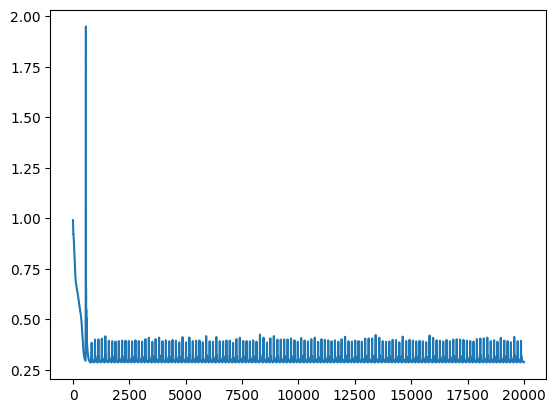

In [162]:
# ----------------
plt.plot([loss.detach().numpy() for loss in loss_l]);

### Plotting results

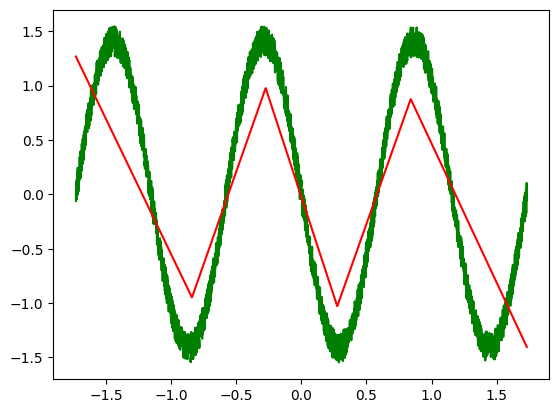

In [163]:
# ----------------
plt.plot(x_data.numpy(), y_data.numpy(), 'g')
plt.plot(x_data.numpy(), y_pred.detach().numpy(), 'r')

### Display the weights and the biases

Now, we want to check the effect of L1 regularization. For this you will plot the values of the weights of each layers.

[[ 4.5130527e-01]
 [-1.4667982e+00]
 [-6.3058431e-44]
 [-2.6146584e+00]
 [-1.5923158e+00]
 [ 4.6938142e-01]
 [ 1.5434443e+00]
 [-6.3058431e-44]
 [-2.6101565e+00]
 [-1.2658273e+00]]
[ 3.7807721e-01  1.2312292e+00 -6.3058431e-44  7.2610420e-01
 -1.3303807e+00  3.9329591e-01 -1.2950095e+00 -6.3058431e-44
 -7.2345269e-01 -1.0576181e+00]
[[ 5.8834350e-01 -1.9148773e+00  6.3058431e-44  2.7065446e+00
   2.0602911e+00  6.1195719e-01 -2.0147517e+00  6.3058431e-44
  -2.6884496e+00  1.6378605e+00]]
[-0.04497771]


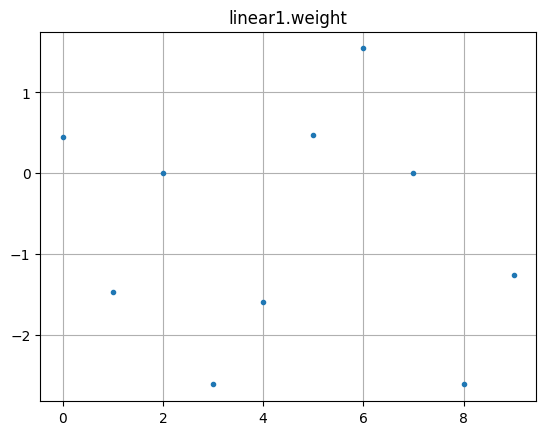

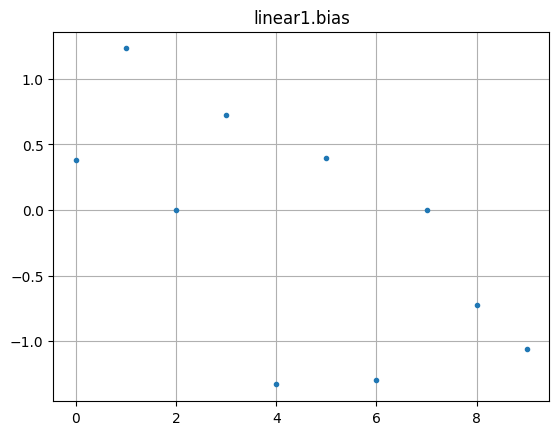

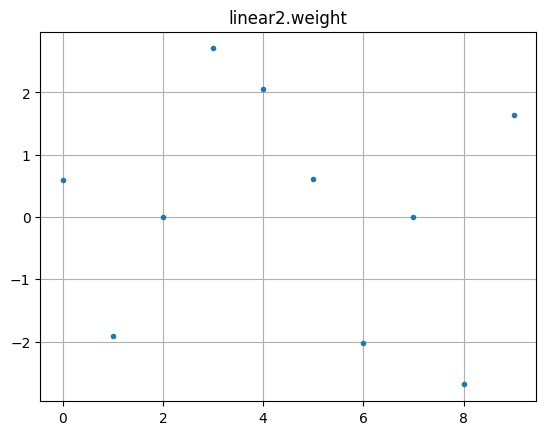

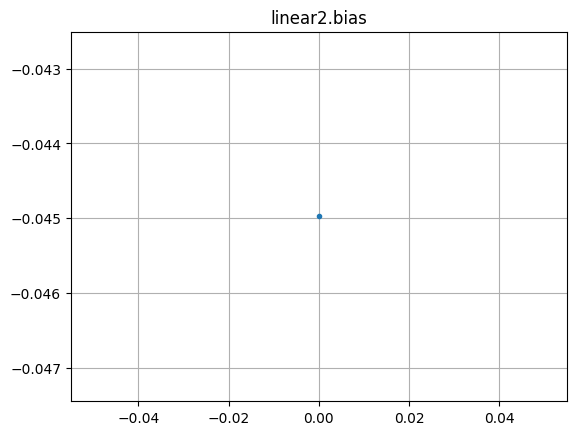

In [164]:
list_l = [{'name':name, 'data':layer.data} for name, layer in model.named_parameters()]
for tmp in list_l:
    plt.figure()
    plt.plot(tmp['data'].flatten().numpy(), '.')
    plt.title(tmp['name'])
    plt.grid(True)
    print(tmp['data'].numpy())